In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [4]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 84.7 MB/s eta 0:00:00


In [5]:
import pennylane as qml

In [6]:
def DosLocal(ncubits, theta, reps = 1):
    theta = theta[0]
    for r in range(reps):
        for i in range(ncubits):
            qml.RY(theta[r * ncubits + i], wires = i)
        for i in range(ncubits - 1):
            qml.CNOT(wires = [i, i + 1])

    for i in range(ncubits):
        qml.RY(theta[reps * ncubits + i], wires = i)

In [7]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [8]:
ncubits = 4
reps_fv = 3
dev = qml.device("lightning.qubit", wires = ncubits)
@qml.qnode(dev, interface = "torch")
def nodo(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(ncubits))
    DosLocal(ncubits, weights, reps_fv)
    return qml.expval(qml.Hermitian(M, wires = [0]))

forma_pesos = {"weights": (1,(reps_fv + 1) * ncubits)}
qlayer = qml.qnn.TorchLayer(nodo, forma_pesos)

In [9]:
import torch

import torch.nn as nn
import torch.nn.functional as F


In [10]:
class TorchClassifier(nn.Module):

    def __init__(self):
        super(TorchClassifier, self).__init__()
        self.layer1 = nn.Linear(16, 8)
        self.layer2 = nn.Linear(8, 4)
        #self.layer3 = nn.Linear(4, 2)
        #self.layer4 = nn.Linear(2, 1)
        self.layer3_q = qlayer

    def forward(self, x):
        x = F.elu(self.layer1(x))
        x = F.elu(self.layer2(x))
        #x = F.elu(self.layer3(x))
        #x = torch.sigmoid(self.layer4(x))
        x = self.layer3_q(x)
        return x

In [11]:
model = TorchClassifier()
print(model)

TorchClassifier(
  (layer1): Linear(in_features=16, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=4, bias=True)
  (layer3_q): <Quantum Torch Layer: func=nodo>
)


In [12]:
model(torch.rand(16))

tensor(0.2473, grad_fn=<ExecuteTapesBackward>)

In [14]:
x, y = make_classification(n_samples = 1000, n_features = 16)

x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [13]:
from torch.utils.data import Dataset

class NumpyDataset(Dataset):
    def __init__(self, x, y):

        if (x.shape[0] != y.shape[0]):
            raise Exception("incompatible arrays")

        y = y.reshape(-1,1)

        self.x = torch.from_numpy(x).to(torch.float)
        self.y = torch.from_numpy(y).to(torch.float).squeeze()

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.y.shape[0]

In [15]:
tr_data = NumpyDataset(x_tr, y_tr)
val_data = NumpyDataset(x_val, y_val)
test_data = NumpyDataset(x_test, y_test)

In [16]:
print(tr_data[0])
print("Length:", len(tr_data))

(tensor([-1.4654, -1.2624, -2.0940, -0.3219, -2.8531,  0.2730, -1.4147,  1.8889,
         1.2667,  0.4820,  0.1064,  1.0219, -0.7237,  0.8997,  1.4372, -1.3651]), tensor(1.))
Length: 800


In [17]:
from torch.utils.data import DataLoader
tr_loader = iter(DataLoader(tr_data, batch_size = 2, shuffle = True))
print(next(tr_loader))

[tensor([[ 1.8813,  0.8235,  2.1924,  1.6593, -0.9943, -0.9885,  1.7046,  1.1423,
         -1.9024, -1.0972,  2.0192,  1.0986, -0.4832, -0.5643, -2.1163,  0.2645],
        [-1.1795,  0.6728,  0.3621,  0.5588, -0.2049, -0.5372,  0.9489,  1.1196,
         -1.3299,  1.7486,  1.2142,  0.2266, -1.3972,  0.1752, -1.4833,  1.0811]]), tensor([0., 0.])]


In [18]:
get_loss = F.binary_cross_entropy

In [19]:
print(get_loss(torch.tensor([1.]), torch.tensor([1.])))

tensor(0.)


In [20]:
tr_loader = DataLoader(tr_data, batch_size = 100, shuffle = True)
opt = torch.optim.Adam(model.parameters(), lr = 0.005)

In [21]:
def run_epoch(opt, tr_loader):
    for data in iter(tr_loader):
        x, y = data
        opt.zero_grad()
        loss = get_loss(model(x), y)
        loss.backward()
        opt.step()

    return get_loss(model(tr_data.x), tr_data.y).detach()

In [22]:
tr_losses = []
val_losses = []

In [23]:
while len(val_losses) < 2 or val_losses[-1] < val_losses[-2]:
    print("EPOCH", len(tr_losses) + 1, end = " ")
    tr_losses.append(float(run_epoch(opt, tr_loader)))
    val_losses.append(float(get_loss(model(val_data.x), val_data.y).detach()))
    print("| Train loss:", round(tr_losses[-1],4), end = " ")
    print("| Valid loss:", round(val_losses[-1],4))

EPOCH 1 | Train loss: 0.7272 | Valid loss: 0.7162
EPOCH 2 | Train loss: 0.6659 | Valid loss: 0.6608
EPOCH 3 | Train loss: 0.6321 | Valid loss: 0.6264
EPOCH 4 | Train loss: 0.5963 | Valid loss: 0.589
EPOCH 5 | Train loss: 0.5487 | Valid loss: 0.5422
EPOCH 6 | Train loss: 0.5044 | Valid loss: 0.493
EPOCH 7 | Train loss: 0.4658 | Valid loss: 0.4445
EPOCH 8 | Train loss: 0.4297 | Valid loss: 0.4034
EPOCH 9 | Train loss: 0.3971 | Valid loss: 0.3749
EPOCH 10 | Train loss: 0.373 | Valid loss: 0.3543
EPOCH 11 | Train loss: 0.356 | Valid loss: 0.3385
EPOCH 12 | Train loss: 0.3421 | Valid loss: 0.314
EPOCH 13 | Train loss: 0.3323 | Valid loss: 0.293
EPOCH 14 | Train loss: 0.3248 | Valid loss: 0.2834
EPOCH 15 | Train loss: 0.3184 | Valid loss: 0.2848


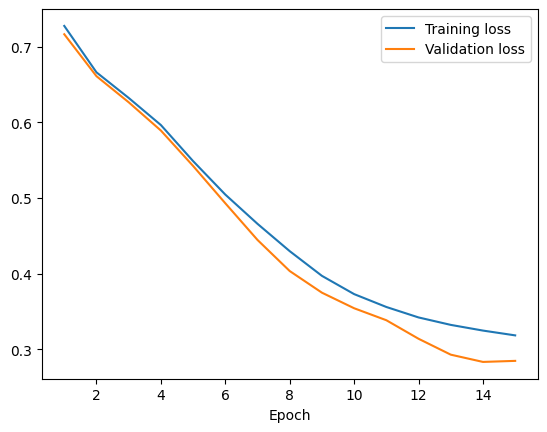

In [24]:
import matplotlib.pyplot as plt
def plot_losses(tr_loss, val_loss):
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_losses(tr_losses, val_losses)

In [25]:
train_acc = accuracy_score(
    (model(tr_data.x) >= 0.5).to(float), tr_data.y)
val_acc = accuracy_score(
    (model(val_data.x) >= 0.5).to(float), val_data.y)
test_acc = accuracy_score(
    (model(test_data.x) >= 0.5).to(float), test_data.y)
print("Training accuracy:", train_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)

Training accuracy: 0.87625
Validation accuracy: 0.93
Test accuracy: 0.89
